# Project 02 - Image Processing

## Thông tin sinh viên

- Họ và tên: Nguyễn Thu Thảo
- MSSV: 23127119
- Lớp: 23CLC02

## Import các thư viện liên quan

In [ ]:
from PIL import Image # for read, write image
import numpy as np # for matrix compute
import matplotlib.pyplot as plt # for show image
import colorsys # for convert RGB to HSL

## Helper functions

In [ ]:
# Any optional parameters beyond the required ones should be defined with default values

def read_img(img_path):
  img_2d = np.array(Image.open(img_path))
  if img_2d.shape[-1] == 4:
    img_2d = img_2d[ : , : , : 3]  # ensuring only using rgb
  return img_2d

def show_img(img_2d):
  plt.imshow(img_2d)
  plt.axis('off')
  plt.show()

def save_img(img_2d, img_path):
  img = Image.fromarray(img_2d.astype('uint8'))
  img.save(img_path)

def convert_rgb_to_hsl(img_2d):
  ''' Convert RGB image to HSL image
  returns a 2D image (numpy array)
  '''
  r, g, b = img_2d[..., 0]/255.0, img_2d[..., 1]/255.0, img_2d[..., 2]/255.0
  hls = np.vectorize(lambda r, g, b: colorsys.rgb_to_hls(r, g, b),
                     otypes=[np.float32, np.float32, np.float32])
  h, l, s = hls(r, g, b)
  h = (h * 360.0) % 360.0
  h = np.clip(h, 0, 360)
  return np.stack([h, s, l], axis=-1)

def convert_hsl_to_rgb(img_2d):
  ''' Convert HSL image to RGB image
  returns a 2D image (numpy array)
  '''
  h, s, l = img_2d[..., 0], img_2d[..., 1], img_2d[..., 2]
  h_normalized = h / 360.0
  rgb = np.vectorize(lambda h, l, s: colorsys.hls_to_rgb(h, l, s),
                     otypes=[np.float32, np.float32, np.float32])
  r, g, b = rgb(h_normalized, l, s)
  rgb = np.stack([r, g, b], axis=-1)
  rgb = (rgb * 255).round().clip(0, 255).astype(np.uint8)
  return rgb

def change_brightness(img_2d, brightness=0):
  new_img = img_2d.astype(np.float32) + brightness
  new_img = np.clip(new_img, 0, 255).astype(np.uint8)
  return new_img

def change_contrast(img_2d, contrast=0):
  factor = (259 * (contrast + 255)) / (255 * (259 - contrast))
  new_img = img_2d.astype(np.float32)
  new_img = factor * (new_img - 128) + 128
  new_img = np.clip(new_img, 0, 255).astype(np.uint8)
  return new_img

def flip(img_2d, dir='h'):
  if dir == 'h':
    return img_2d[ : , : : -1]
  else:
    return img_2d[ : :-1, : ]

def rgb_to_grey(img_2d):
  r, g, b = img_2d[ : , : , 0], img_2d[ : , : , 1], img_2d[ : , : , 2]
  gray = 0.299*r + 0.587*g + 0.114*b
  new_img = np.stack([gray]*3, axis=-1).astype(np.uint8)
  return new_img

def rgb_to_sepia(img_2d):
  sepia = np.array([[0.393, 0.769, 0.189],
                    [0.349, 0.686, 0.168],
                    [0.272, 0.534, 0.131]])
  new_img = img_2d.astype(np.float32)
  new_img = new_img @ sepia.T
  new_img = np.clip(new_img, 0, 255).astype(np.uint8)
  return new_img

# for kernel
def convolve(img_2d, kernel):
  kh, kw = kernel.shape
  pad = kh // 2
  new_img = np.zeros(img_2d.shape, dtype=np.float32)
  padded_img = np.pad(img_2d.astype(np.float32), ((pad, pad), (pad, pad), (0, 0)), mode='constant')
  for i in range(pad, img_2d.shape[0] + pad):
      for j in range(pad, img_2d.shape[1] + pad):
          for k in range(3):
              region = padded_img[i-pad:i+pad+1, j-pad:j+pad+1, k]
              new_img[i-pad, j-pad, k] = np.sum(region * kernel)
  new_img = np.clip(new_img, 0, 255)
  return new_img.astype(np.uint8)

def circular_mask(img_2d):
  height, width = img_2d.shape[:2]
  center = (width//2, height//2)
  radius = min(width, height) // 2
  y, x = np.ogrid[:height, :width]
  mask = (((x - center[0])**2 + (y - center[1])**2) <= radius**2)
  new_img = np.zeros_like(img_2d)
  for c in range(3):
    new_img[ : , : , c] = img_2d[ : , : , c] * mask # become (0, 0, 0)  if outside border (False)
  return new_img

# def ellipse_mask(img_2d):
#   height, width = img_2d.shape[:2]
#   center = (width//2, height//2)
#   cross = (width**2 + height**2)**0.5
#   deg = np.arcsin((width/2)/(cross/2))
#   axes = (cross//6, cross//2.5)
#   y, x = np.ogrid[:height, :width]
#   # first eclipse: +45 degree
#   nx1 = (x - center[0]) * np.cos(deg) + (y - center[1]) * np.sin(deg)
#   ny1 = -(x - center[0]) * np.sin(deg) + (y - center[1]) * np.cos(deg)
#   mask1 = ((nx1**2 / axes[0]**2 + ny1**2 / axes[1]**2) <= 1)
#   # second eclipse: -45 degree
#   nx2 = (x - center[0]) * np.cos(-deg) + (y - center[1]) * np.sin(-deg)
#   ny2 = -(x - center[0]) * np.sin(-deg) + (y - center[1]) * np.cos(-deg)
#   mask2 = ((nx2**2 / axes[0]**2 + ny2**2 / axes[1]**2) <= 1)
#   mask = np.logical_or(mask1, mask2)
#   new_img = np.zeros_like(img_2d)
#   for c in range(3):
#     new_img[ : , : , c] = img_2d[ : , : , c] * mask
#   return new_img

def ellipse_mask(img_2d):
  height, width = img_2d.shape[:2]
  center = (width//2, height//2)
  # Rectangle diagonal (cross)
  cross = np.sqrt(width**2 + height**2)
  # Rectangle half-width and half-height
  w = width / 2
  h = height / 2
  # Semi-major axis: half the diagonal (ellipse line = cross)
  a = cross / 2
  # Semi-minor axis: ensure ellipse fits within image
  b = np.sqrt((w**2 * h**2) / (w**2 + h**2))
  axes = (a, b)
  # Angle of diagonal
  deg = np.arctan2(height, width)  # Use arctan2 for correct quadrant
  y, x = np.ogrid[:height, :width]
  # First ellipse: aligned with diagonal (angle = deg)
  nx1 = (x - center[0]) * np.cos(deg) + (y - center[1]) * np.sin(deg)
  ny1 = -(x - center[0]) * np.sin(deg) + (y - center[1]) * np.cos(deg)
  mask1 = ((nx1**2 / axes[0]**2 + ny1**2 / axes[1]**2) <= 1)
  # Second ellipse: aligned with opposite diagonal (angle = -deg)
  nx2 = (x - center[0]) * np.cos(-deg) + (y - center[1]) * np.sin(-deg)
  ny2 = -(x - center[0]) * np.sin(-deg) + (y - center[1]) * np.cos(-deg)
  mask2 = ((nx2**2 / axes[0]**2 + ny2**2 / axes[1]**2) <= 1)
  mask = np.logical_or(mask1, mask2)
  new_img = np.zeros_like(img_2d)
  for c in range(3):
      new_img[:, :, c] = img_2d[:, :, c] * mask
  return new_img

  return new_img

def process_image(img_2d, func=[1, 2, 3,...]):
  ''' Process image with a list of functions
  func: a list of functions to apply to the image
  return processed 2D image
  '''
  processed_img = []
  for f in func:
    # if f == 0: break
    if f == 1:
      # up brightness
      brightness = 50
      new_img = change_brightness(img_2d, brightness)
      processed_img.append(new_img)
      new_img = change_brightness(img_2d, -brightness)
      processed_img.append(new_img)
    elif f == 2:
      # up contrast
      contrast = 50
      new_img = change_contrast(img_2d, contrast)
      processed_img.append(new_img)
      new_img = change_contrast(img_2d, -contrast)
      processed_img.append(new_img)
    elif f == 3:
      # flip horizontal
      new_img = flip(img_2d, 'h')
      processed_img.append(new_img)

      # flip vertical
      new_img = flip(img_2d, 'v')
      processed_img.append(new_img)
    elif f == 4:
      # rgb to grey
      new_img = rgb_to_grey(img_2d)
      processed_img.append(new_img)

      # rgb to sepia
      new_img = rgb_to_sepia(img_2d)
      processed_img.append(new_img)
    elif f == 5:
      # blur
      kernel = np.array([[1, 2, 1],
                         [2, 4, 2],
                         [1, 2, 1]])
      kernel = kernel / np.sum(kernel)
      new_img = convolve(img_2d, kernel)
      processed_img.append(new_img)

      # sharpen
      kernel = np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]])
      kernel = kernel / np.sum(kernel)
      new_img = convolve(img_2d, kernel)
      processed_img.append(new_img)
    elif f == 6:
      # crop
      height, width = img_2d.shape[:2]
      new_img = img_2d[height//4 : height*3//4, width//4 : width*3//4, : ]
      processed_img.append(new_img)
    elif f == 7:
      # circular mask
      new_img = circular_mask(img_2d)
      processed_img.append(new_img)

      # ellipse mask
      new_img = ellipse_mask(img_2d)
      processed_img.append(new_img)

  return processed_img

## Your tests

In [ ]:
# for easier testing
func_choice = [1, 2, 3, 4, 5, 6, 7]
functions = ["brightness_up", "brightness_down"
              "contrast_up", "contrast_down"
              "flip_horizontal", "flip_vertical",
              "rgb_to_grey", "rgb_to_sepia",
              "blur", "sharpen",
              "crop",
              "circular_crop", "ellipsse_crop"]

## Main FUNCTION

Nhập image path: /content/1.jpg
Default image:
Image shape: (512, 512, 3)


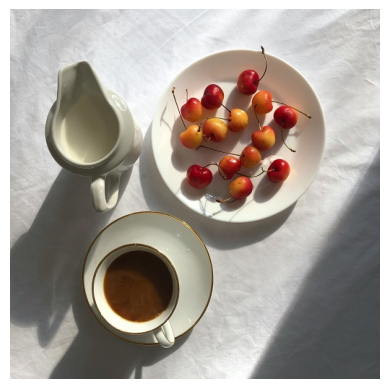

Image sau khi đổi từ RGB sang HSL sang RGB:


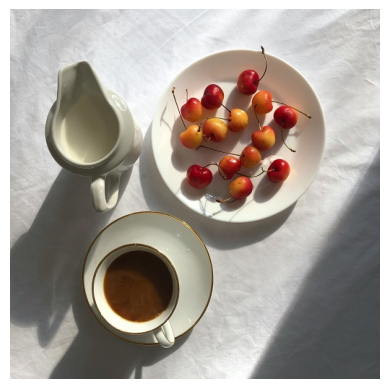

0. Lưu ảnh. 
1. Thay đổi độ sáng cho ảnh 
2. Thay đổi độ tương phản 
3. Lật ảnh (ngang + dọc) 
4. Chuyển đổi ảnh RGB thành ảnh xám/sepia 
5. Làm mờ + sắc nét ảnh 
6. Cắt 1/4 ảnh theo kích thước (cắt ở trung tâm) 
7. Cắt ảnh theo khung 

Chọn lựa chọn (0-7): 7
Chọn lựa chọn (0-7): 0


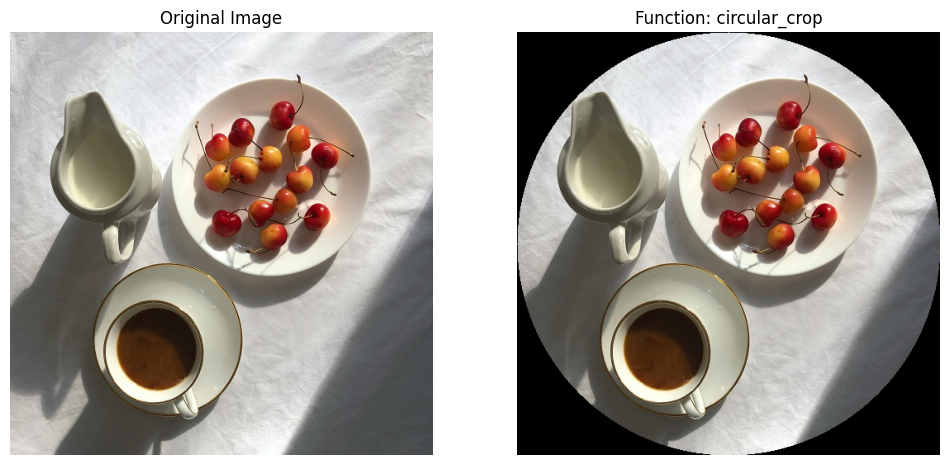

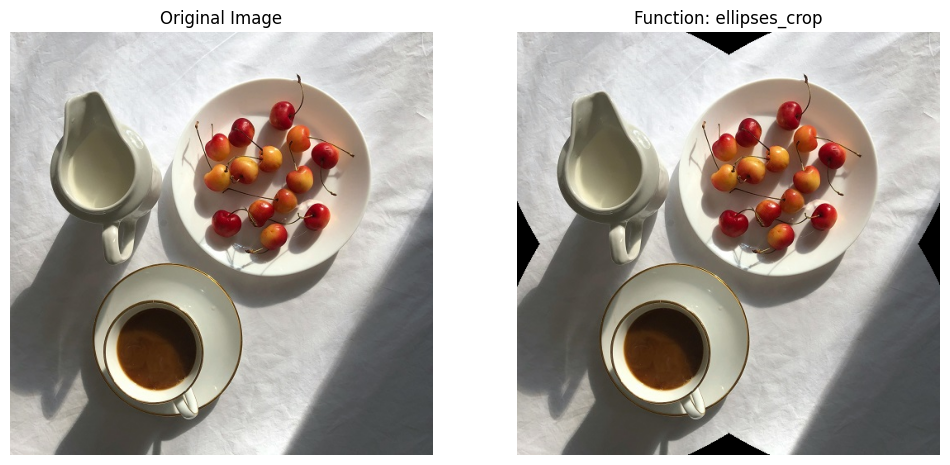

In [ ]:
def main():
  img_path = input("Nhập image path: ")
  img_2d = read_img(img_path)
  print("Default image:")
  print(f"Image shape: {img_2d.shape}")
  show_img(img_2d)

  print("Image sau khi đổi từ RGB sang HSL sang RGB:")
  show_img(convert_hsl_to_rgb(convert_rgb_to_hsl(img_2d)))

  func = []
  func_name = []

  # func = func_choice
  # func_name = functions
  print("0. Lưu ảnh. \n"
        "1. Thay đổi độ sáng cho ảnh \n"
        "2. Thay đổi độ tương phản \n"
        "3. Lật ảnh (ngang + dọc) \n"
        "4. Chuyển đổi ảnh RGB thành ảnh xám/sepia \n"
        "5. Làm mờ + sắc nét ảnh \n"
        "6. Cắt 1/4 ảnh theo kích thước (cắt ở trung tâm) \n"
        "7. Cắt ảnh theo khung \n")
  while True:
      choice = int(input("Chọn lựa chọn (0-7): "))
      try:
        if choice == 0:
            break
        if choice < 1 or choice > 7:
          print("Lựa chọn phải từ 1 đến 7\n")
        else:
          func.append(choice)
          if choice == 1:
            func_name.append("brightness_up")
            func_name.append("brightness_down")
          elif choice == 2:
            func_name.append("contrast_up")
            func_name.append("contrast_down")
          elif choice == 3:
            func_name.append("flip_horizontal")
            func_name.append("flip_vertical")
          elif choice == 4:
            func_name.append("rgb_to_grey")
            func_name.append("rgb_to_sepia")
          elif choice == 5:
            func_name.append("blur")
            func_name.append("sharpen")
          elif choice == 6:
            func_name.append("crop")
          elif choice == 7:
            func_name.append("circular_crop")
            func_name.append("ellipses_crop")
      except ValueError:
            print("Invalid. Nhập số từ 0 đến 7. \n")

  if not func:
    print("No functions chosen. \n")
    return
  process_img = process_image(img_2d, func)

  base_name = img_path.split('.')[0]
  extension = img_path.split('.')[-1]

  for i, img in enumerate(process_img):
    # show_img(img)
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(img_2d)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(img)
    plt.title(f'Function: {func_name[i]}')
    plt.axis('off')
    plt.show()

    save_img(img, f"{base_name}_{func_name[i]}.{extension}")

if __name__ == "__main__":
    main()